# CUDA

In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

# Load modules

In [14]:
import torch
from torch.utils.data import DataLoader
import pickle as pkl
from persite_painn.nn.builder import get_model_list
from persite_painn.data import collate_dicts
from persite_painn.utils.cuda import batch_to
# from persite_painn.train import Normalizer, load_model"
from persite_painn.utils import ensemble_inference, plot_violin
import numpy as np
from persite_painn.utils import plot_scatter
%config InlineBackend.figure_formats = ['svg']
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

In [22]:
# dataset = torch.load("../data_cache/1-sac-paper/sac_multifidelity_15round")
# original_dataset = pkl.load(open("../data_raw/data_sac_total_0130.pkl", "rb"))
model_path = "models/m_painn/2_components/"

model_list = get_model_list(model_path=model_path, model_type="PainnMultifidelity")
baseline_model_path = "models/per_site_painn"
baseline_model_list = get_model_list(model_path=baseline_model_path, model_type="Painn")

In [18]:
original_dataset = pkl.load(open("../data_raw/dataset_2_components.pkl", "rb"))

In [5]:
test_dataset = torch.load("../data_cache/testset")
test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    num_workers=0,
    collate_fn=collate_dicts,
)

In [10]:
def test_model_list(
    model_list,
    data_loader,
    device,
    normalizer=None,
    multifidelity=False,
):
    """
    test the model performances
    Args:
        model: Model,
        data_loader: DataLoader,
        metric_fn: metric function,
        device: "cpu" or "cuda",
    Return:
        Lists of prediction, targets, ids, and metric
    """
    test_targets = []
    test_preds = []
    test_ids = []
    test_targets_fidelity = []
    test_preds_fidelity = []

    with torch.no_grad():
        for batch in data_loader:
            batch = batch_to(batch, device)
            target = batch["target"]
            # Compute output
            
            output = ensemble_inference(model_list, batch, normalizer, "target", device)
            # Rearrange the outputs
            test_pred = output.data.cpu()
            test_target = target.detach().cpu()

            batch_ids = []
            count = 0
            num_bin = []
            for i, val in enumerate(batch["num_atoms"].detach().cpu().numpy()):
                count += val
                num_bin.append(count)
                if i == 0:
                    change = list(np.arange(val))
                else:
                    adding_val = num_bin[i - 1]
                    change = list(np.arange(val) + adding_val)
                batch_ids.append(change)

            test_preds += [test_pred[i].tolist() for i in batch_ids]
            test_targets += [test_target[i].tolist() for i in batch_ids]

            if multifidelity:
                target_fidelity = batch["fidelity"].detach().cpu()
                # Compute output
                output_fidelity = ensemble_inference(model_list, batch, normalizer, "fidelity", device).data.cpu()

                test_preds_fidelity += [output_fidelity[i].tolist() for i in batch_ids]
                test_targets_fidelity += [
                    target_fidelity[i].tolist() for i in batch_ids
                ]
            if isinstance(batch["name"], list):
                test_ids += batch["name"]
            else:
                test_ids += batch["name"].detach().tolist()
    return (
        test_preds,
        test_targets,
        test_ids,
        test_preds_fidelity,
        test_targets_fidelity,
    )


In [11]:
test_preds,test_targets, test_ids,test_preds_fidelity, test_targets_fidelity = test_model_list(model_list,
    test_loader,
    "cuda",
    normalizer=None,
    multifidelity=True,
)

2023-11-11 16:04:24,428|WARNING|findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
2023-11-11 16:04:24,435|WARNING|findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
2023-11-11 16:04:24,523|WARNING|findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


O adsorption: 28, OH adsorption: 27


2023-11-11 16:04:24,605|WARNING|findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


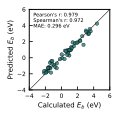

In [13]:
targs_O = []
targs_OH = []
targs_E = []

preds_O = []
preds_OH = []
preds_E = []

for batch in test_targets:
    for site in batch:
        targs_O.append(site[0])
        targs_OH.append(site[1])

for batch in test_preds:
    for site in batch:
        preds_O.append(site[0])
        preds_OH.append(site[1])

nan_filter_O = torch.bitwise_not(torch.isnan(torch.tensor(targs_O)))
# print(torch.tensor(targs_O).shape, torch.tensor(preds_O).shape)
filtered_targs_O = torch.tensor(targs_O)[nan_filter_O].tolist()
filtered_preds_O = torch.tensor(preds_O)[nan_filter_O].tolist()

nan_filter_OH = torch.bitwise_not(torch.isnan(torch.tensor(targs_OH)))
# print(torch.tensor(targs_OH).shape, torch.tensor(preds_OH).shape)
filtered_targs_OH = torch.tensor(targs_OH)[nan_filter_OH].tolist()
filtered_preds_OH = torch.tensor(preds_OH)[nan_filter_OH].tolist()
print(f"O adsorption: {len(filtered_targs_O)}, OH adsorption: {len(filtered_targs_OH)}")
combined_targs = []
combined_preds = []
for val in filtered_targs_O:
    combined_targs.append(val)
for val in filtered_targs_OH:
    combined_targs.append(val)
for val in filtered_preds_O:
    combined_preds.append(val)
for val in filtered_preds_OH:
    combined_preds.append(val)

fig_combined, _ ,_, mae = plot_scatter(combined_targs, combined_preds, num_col=4, target_index=0, prop_key="ads_e", facecolor="#1D7874", edgecolor='black', style='scifig')
fig_combined.tight_layout()
fig_combined.savefig('m-painn.png', dpi=500, transparent=True)


# Per-site Painn

In [24]:
test_preds_baseline,test_targets_baseline, test_ids_base_line,_, _ = test_model_list(baseline_model_list,
    test_loader,
    "cuda",
    normalizer=None,
    multifidelity=False,
)

O adsorption: 28, OH adsorption: 27


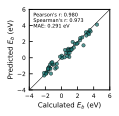

In [25]:
targs_O = []
targs_OH = []
targs_E = []

preds_O = []
preds_OH = []
preds_E = []

for batch in test_targets_baseline:
    for site in batch:
        targs_O.append(site[0])
        targs_OH.append(site[1])

for batch in test_preds_baseline:
    for site in batch:
        preds_O.append(site[0])
        preds_OH.append(site[1])

nan_filter_O = torch.bitwise_not(torch.isnan(torch.tensor(targs_O)))
# print(torch.tensor(targs_O).shape, torch.tensor(preds_O).shape)
filtered_targs_O = torch.tensor(targs_O)[nan_filter_O].tolist()
filtered_preds_O = torch.tensor(preds_O)[nan_filter_O].tolist()

nan_filter_OH = torch.bitwise_not(torch.isnan(torch.tensor(targs_OH)))
# print(torch.tensor(targs_OH).shape, torch.tensor(preds_OH).shape)
filtered_targs_OH = torch.tensor(targs_OH)[nan_filter_OH].tolist()
filtered_preds_OH = torch.tensor(preds_OH)[nan_filter_OH].tolist()
print(f"O adsorption: {len(filtered_targs_O)}, OH adsorption: {len(filtered_targs_OH)}")
combined_targs = []
combined_preds = []
for val in filtered_targs_O:
    combined_targs.append(val)
for val in filtered_targs_OH:
    combined_targs.append(val)
for val in filtered_preds_O:
    combined_preds.append(val)
for val in filtered_preds_OH:
    combined_preds.append(val)

fig_combined, _ ,_, mae = plot_scatter(combined_targs, combined_preds, num_col=4, target_index=0, prop_key="ads_e", facecolor="#1D7874", edgecolor='black', style='scifig')
fig_combined.tight_layout()
fig_combined.savefig('persite-painn.png', dpi=500, transparent=True)


In [16]:
def get_filtered_fidelity(targs, preds):
    targs_magmom = []
    targs_bandfilling = []
    targs_atomiccharges = []
    targs_bandcenter = []
    preds_magmom = []
    preds_bandfilling = []
    preds_atomiccharges = []
    preds_bandcenter = []
    for structure in targs:
        for site in structure:
            targs_bandcenter.append(site[0])
            targs_atomiccharges.append(site[1])
            targs_bandfilling.append(site[2])
            targs_magmom.append(site[3])
    for structure in preds:
        for site in structure:
            preds_bandcenter.append(site[0])
            preds_atomiccharges.append(site[1])
            preds_bandfilling.append(site[2])
            preds_magmom.append(site[3])

    nan_filter_bandfilling = torch.bitwise_not(torch.isnan(torch.tensor(targs_bandfilling)))
    filtered_targs_bandfilling = torch.tensor(targs_bandfilling)[nan_filter_bandfilling].tolist()
    filtered_preds_bandfilling = torch.tensor(preds_bandfilling)[nan_filter_bandfilling].tolist()

    nan_filter_bandcenter = torch.bitwise_not(torch.isnan(torch.tensor(targs_bandcenter)))
    filtered_targs_bandcenter = torch.tensor(targs_bandcenter)[nan_filter_bandcenter].tolist()
    filtered_preds_bandcenter = torch.tensor(preds_bandcenter)[nan_filter_bandcenter].tolist()

    nan_filter_atomiccharges = torch.bitwise_not(torch.isnan(torch.tensor(targs_atomiccharges)))
    filtered_targs_atomiccharges = torch.tensor(targs_atomiccharges)[nan_filter_atomiccharges].tolist()
    filtered_preds_atomiccharges = torch.tensor(preds_atomiccharges)[nan_filter_atomiccharges].tolist()

    nan_filter_magmom = torch.bitwise_not(torch.isnan(torch.tensor(targs_magmom)))
    filtered_targs_magmom = torch.tensor(targs_magmom)[nan_filter_magmom].tolist()
    filtered_preds_magmom = torch.tensor(preds_magmom)[nan_filter_magmom].tolist()
    removed_small_magmom_targs = []
    idx_bin = []
    for i, val in enumerate(filtered_targs_magmom):
        if val > 0.5:
            removed_small_magmom_targs.append(val)
            idx_bin.append(i)

    removed_small_magmom_preds = np.array(filtered_preds_magmom)[idx_bin]

    return (filtered_targs_bandcenter, filtered_preds_bandcenter), (filtered_targs_atomiccharges, filtered_preds_atomiccharges), (filtered_targs_bandfilling, filtered_preds_bandfilling), (removed_small_magmom_targs, removed_small_magmom_preds)

0.0968748761248955
0.10821674928129654
0.11169335789586027
0.17033054190209884


100%|██████████| 403/403 [00:00<00:00, 5895.13it/s]


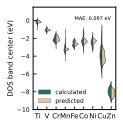

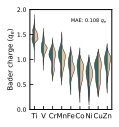

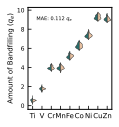

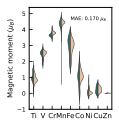

In [19]:
fidelity_mae_bin = []
bancenters, atomiccharges, bandfillings, magmoms = get_filtered_fidelity(test_targets_fidelity, test_preds_fidelity)
mae_bandcenter  = mean_absolute_error(bancenters[0], bancenters[1])
print(mae_bandcenter)
mae_bader  = mean_absolute_error(atomiccharges[0], atomiccharges[1])
print(mae_bader)

mae_bandfilling  = mean_absolute_error(bandfillings[0], bandfillings[1])
print(mae_bandfilling)

mae_magmom  = mean_absolute_error(magmoms[0], magmoms[1])
print(mae_magmom)

fig, ax = plot_violin(test_targets_fidelity, test_preds_fidelity,  0, num_col=4, test_ids=test_ids, structures=original_dataset,prop_key='bandcenter', color1="#1D7874",Z_range=[22,23,24,25,26,27,28,29, 30], legend=True)
ax.set_ylim(-10, 1.5)
ax.annotate(f"MAE: {mae_bandcenter:.3f} eV", (0.5,0.875), xycoords='axes fraction', fontsize=5)
# yticks = ax.get_yticks()
# ax.set_yticklabels(['{:.1f}'.format(val) for val in yticks])
fig.tight_layout()
fig.savefig("bandcenter.png", dpi=500, transparent=True)

fig, ax = plot_violin(test_targets_fidelity, test_preds_fidelity,  1, num_col=4,test_ids=test_ids, structures=original_dataset,prop_key='bader', Z_range=[22,23,24,25,26,27,28,29, 30],color1="#1D7874", legend=False)
ax.annotate(f"MAE: {mae_bader:.3f} $q_e$", (0.5,0.875), xycoords='axes fraction', fontsize=5)
ax.set_ylim(0.0, 2.0)
ax.set_yticks([0.0, 0.5, 1.0, 1.5, 2.0])
yticks = ax.get_yticks()
# ax.set_yticklabels(['{:.1f}'.format(val) for val in yticks])
fig.tight_layout()
fig.savefig("atomiccharges.png", dpi=500, transparent=True)

fig, ax = plot_violin(test_targets_fidelity, test_preds_fidelity,  2, num_col=4, test_ids=test_ids, structures=original_dataset,prop_key='bandfilling', Z_range=[22,23,24,25,26,27,28,29, 30], color1="#1D7874",legend=False)
# yticks = ax.get_yticks()
ax.annotate(f"MAE: {mae_bandfilling:.3f} $q_e$", (0.1,0.875), xycoords='axes fraction', fontsize=5)
# ax.set_yticklabels(['{:.1f}'.format(val) for val in yticks])
# ax.set_aspect("equal")
fig.tight_layout()
fig.savefig("bandfilling.png", dpi=500, transparent=True)

fig, ax = plot_violin(test_targets_fidelity, test_preds_fidelity,  3, num_col=4, test_ids=test_ids, structures=original_dataset,prop_key='magmom', Z_range=[22,23,24,25,26,27,28,29, 30], color1="#1D7874",legend=False)
# yticks = ax.get_yticks()
ax.annotate(f"MAE: {mae_magmom:.3f} $\mu_B$", (0.5,0.875), xycoords='axes fraction', fontsize=5)
# ax.set_yticklabels(['{:.1f}'.format(val) for val in yticks])
# ax.set_aspect("equal")
fig.tight_layout()
fig.savefig("magmom.png", dpi=500, transparent=True)
